# 1. Imports necessary libraries and Setup.

In [57]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, Embedding, LSTM, add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from types import SimpleNamespace

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
import nltk
import pickle
import time
import random

# Ensure NLTK punkt is downloaded.

In [26]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pasin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 2. Paths (relative).

In [27]:
BASE_DIR    = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DATA_DIR    = os.path.join(BASE_DIR, 'Mini project - dataset')
IMAGE_DIR   = os.path.join(DATA_DIR, 'Images')
CAPTION_F   = os.path.join(DATA_DIR, 'captions.txt')
OUTPUT_DIR  = os.path.join(BASE_DIR, 'output')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 3. Load and clean captions.

In [28]:
def load_captions(fp):
    d = {}
    with open(fp, 'r', encoding='utf-8') as f:
        for line in f:
            img, cap = line.strip().split(',', 1)
            img_id = img.split('.')[0]
            d.setdefault(img_id, []).append(f"startseq {cap.strip()} endseq")
    return d

def clean_captions(captions):
    return {k: [c.lower() for c in v] for k, v in captions.items()}

print("Loading captions from captions.txt...")
captions = clean_captions(load_captions(CAPTION_F))
print(f"Total images(.jpg) with captions: {len(captions)}")

Loading captions from captions.txt...
Total images(.jpg) with captions: 8092


# 4. Training, Validation, Testing set spliting.

In [29]:
all_ids = list(captions.keys())
np.random.seed(42)
np.random.shuffle(all_ids)

train_ids, temp_ids = train_test_split(all_ids, test_size=0.30, random_state=42)
val_ids, test_ids  = train_test_split(temp_ids, test_size=0.50, random_state=42)
print(f"Training set images: {len(train_ids)}, Validation set images: {len(val_ids)}, Testing set images: {len(test_ids)}")

Training set images: 5664, Validation set images: 1214, Testing set images: 1214


# 5. Tokenizer setup.

- Here we look at the length distribution
    - 95th percentile of caption lengths and 40 is the max length of captions in the dataset

In [30]:
all_caps = [c for caps in captions.values() for c in caps]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_caps)

vocab_size = len(tokenizer.word_index) + 1


lengths = [len(c.split()) for c in all_caps]
p95     = int(np.percentile(lengths, 95))
max_len = min(p95, 40) 

print(f"Vocab size: {vocab_size}") 
print(f"Caption lengths = min: {min(lengths)}, median: {np.median(lengths):.0f}, 95th percentile: {p95}")
print(f"Using max_len = {max_len}")


Vocab size: 8497
Caption lengths = min: 3, median: 13, 95th percentile: 21
Using max_len = 21


# 6. CNN feature extractor definition.

In [31]:
def build_feature_extractor():
    inp = Input(shape=(299, 299, 3))
    x = Conv2D(32, (3,3), activation='relu')(inp)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    return Model(inputs=inp, outputs=x, name='cnn_extractor')

# 7. Extract or load cached features.

In [32]:
feature_path = os.path.join(OUTPUT_DIR, 'cnn_features.pkl')
if os.path.exists(feature_path):
    print("Loading cached features from cnn_features.pkl...")
    with open(feature_path, 'rb') as f:
        features = pickle.load(f)
else:
    print("Extracting features…")
    cnn_ext = build_feature_extractor()
    features = {}
    for img_id in tqdm(train_ids + val_ids + test_ids):
        img_file = os.path.join(IMAGE_DIR, img_id + '.jpg')
        if not os.path.exists(img_file): continue
        img = load_img(img_file, target_size=(299,299))
        arr = img_to_array(img) / 255.0
        feat = cnn_ext.predict(np.expand_dims(arr,0), verbose=0).flatten()
        features[img_id] = feat
    with open(feature_path, 'wb') as f:
        pickle.dump(features, f)
    print("Features saved.")

feature_dim = next(iter(features.values())).shape[0]

Loading cached features from cnn_features.pkl...


# 8. Sequence generation.

- Here we are doing,
    1. pad sequences
    2. pack inputs into a tuple: ((feat, seq), label)

- Instantiate our datasets.

In [33]:
def make_caption_dataset(captions, features, ids, max_len, batch_size=64):
    feature_dim = next(iter(features.values())).shape[0]

    def gen():
        for img_id in ids:
            if img_id not in captions or img_id not in features:
                continue
            feat = features[img_id].astype('float32')
            for cap in captions[img_id]:
                tokens = tokenizer.texts_to_sequences([cap])[0]
                if len(tokens) > max_len:
                    continue
                for j in range(1, len(tokens)):
                    in_seq = np.array(tokens[:j], dtype=np.int32)
                    out_w  = np.int32(tokens[j])
                    yield feat, in_seq, out_w

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(feature_dim,), dtype=tf.float32),
            tf.TensorSpec(shape=(None,),        dtype=tf.int32),
            tf.TensorSpec(shape=(),             dtype=tf.int32),
        )
    )
 
    ds = ds.map(
        lambda feat, seq, y: (
            (feat, tf.pad(seq, [[0, max_len - tf.shape(seq)[0]]])), 
            y
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    ds = ds.shuffle(10_000) \
           .batch(batch_size) \
           .prefetch(tf.data.AUTOTUNE)

    return ds

train_ds = make_caption_dataset(captions, features, train_ids, max_len)
val_ds   = make_caption_dataset(captions, features, val_ids,   max_len)
test_ds  = make_caption_dataset(captions, features, test_ids,  max_len)

# 9. Model builder.

In [34]:
def build_model(embed_dim=128, lstm_units=256, drop=0.3, lr=1e-3):
    i1 = Input(shape=(feature_dim,))
    x1 = Dropout(drop)(i1)
    x1 = Dense(256, activation='relu')(x1)

    i2 = Input(shape=(max_len,))
    x2 = Embedding(vocab_size, embed_dim, mask_zero=True)(i2)
    x2 = Dropout(drop)(x2)
    x2 = LSTM(lstm_units)(x2)

    x = add([x1, Dense(256)(x2)])
    x = Dense(256, activation='relu')(x)
    out = Dense(vocab_size, activation='softmax')(x)

    m = Model([i1, i2], out)
    m.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    return m

# 10. Path to cache your best hyper‐parameters.

- Here we are doing,
    1. Defining the full “search space”
    2. Precompute sequence counts.
    3. Cache the result to disk.

In [ ]:
best_params_path = os.path.join(OUTPUT_DIR, 'best_params.pkl')

if os.path.exists(best_params_path):
    print("Loading cached hyperparameters…")
    with open(best_params_path, 'rb') as f:
        best = pickle.load(f)
else:
    from sklearn.model_selection import ParameterSampler

    param_dist = {
        'embed_dim':   [128],
        'lstm_units':  [256],
        'drop':        [0.3],
        'lr':          [1e-3, 1e-4],
        'batch_size':  [64, 128],
        'epochs':      [5],
    }
    n_iter = 4
    sampler = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

    def count_sequences(ids):
        tot = 0
        for img_id in ids:
            if img_id not in captions or img_id not in features:
                continue
            for cap in captions[img_id]:
                tokens = tokenizer.texts_to_sequences([cap])[0]
                if len(tokens) <= max_len:
                    tot += len(tokens) - 1
        return tot

    train_count = count_sequences(train_ids)
    val_count   = count_sequences(val_ids)

    best = {'loss': np.inf}
    for params in sampler:
        print("Trial:", params)
        steps_per_epoch  = train_count // params['batch_size']
        validation_steps = val_count   // params['batch_size']

        model = build_model(
            embed_dim   = params['embed_dim'],
            lstm_units  = params['lstm_units'],
            drop        = params['drop'],
            lr          = params['lr']
        )

        train_ds_p = make_caption_dataset(
            captions, features, train_ids, max_len,
            batch_size=params['batch_size']
        ).repeat()
        val_ds_p = make_caption_dataset(
            captions, features, val_ids, max_len,
            batch_size=params['batch_size']
        )

        history = model.fit(
            train_ds_p,
            validation_data=val_ds_p,
            epochs=params['epochs'],
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            verbose=0
        )

        val_loss = min(history.history['val_loss'])
        print(f" → val_loss = {val_loss:.4f}")
        if val_loss < best['loss']:
            best = dict(params, loss=val_loss)
 
    with open(best_params_path, 'wb') as f:
        pickle.dump(best, f)
    print(f"Saved best hyperparameters to {best_params_path}")

print("Best hyperparameters:", best)

# 11. Final training on training set + validation set using tf.data with tqdm progress.

- Here we are doing,
    1. Attempt to reload previous full_ids & history.
        - Now we have,
            1.1. Attempt to reload previous full_ids & history.
            1.2. history_dict — dict with keys 'loss','val_loss','accuracy','val_accuracy'.
    2. count_sequences helper.
    3. Combine train & val splits.
    4. Recompute sequence counts and steps.
    5. Build the final model using best hyperparameters.
    6. Build tf.data pipelines.
    7. Callbacks.
    8. Train.
    9. Save training history.
    10. Save combined train+val ID list.

In [ ]:
ids_path       = os.path.join(OUTPUT_DIR, 'full_trainval_ids.pkl')
history_path   = os.path.join(OUTPUT_DIR, 'training_history.pkl')
model_path     = os.path.join(OUTPUT_DIR, 'best_cnn_lstm.h5')

if os.path.exists(ids_path) and os.path.exists(history_path) and os.path.exists(model_path):
    print("Loading cached train+val IDs, history, and model weights…")
    with open(ids_path,     'rb') as f: full_ids     = pickle.load(f)
    with open(history_path, 'rb') as f: history_dict = pickle.load(f)

    model = build_model(
        embed_dim   = best['embed_dim'],
        lstm_units  = best['lstm_units'],
        drop        = best['drop'],
        lr          = best['lr']
    )

    model.load_weights(model_path)

    history = SimpleNamespace(history=history_dict)

    print(f" → Loaded {len(full_ids)} IDs, history keys: {list(history_dict.keys())}")


else:
    for var in [
        'train_img','train_seq','train_y',
        'val_img','val_seq','val_y',
        'test_img','test_seq','test_y'
    ]:
        if var in globals(): del globals()[var]
    import gc; gc.collect()

    def count_sequences(ids):
        tot = 0
        for img_id in ids:
            if img_id not in captions or img_id not in features:
                continue
            for cap in captions[img_id]:
                tokens = tokenizer.texts_to_sequences([cap])[0]
                if len(tokens) <= max_len:
                    tot += len(tokens) - 1
        return tot

    full_ids         = train_ids + val_ids
    full_count       = count_sequences(full_ids)
    val_count        = count_sequences(val_ids)
    steps_per_epoch  = full_count    // best['batch_size']
    validation_steps = val_count     // best['batch_size']

    model = build_model(
        embed_dim   = best['embed_dim'],
        lstm_units  = best['lstm_units'],
        drop        = best['drop'],
        lr          = best['lr']
    )

    full_ds = make_caption_dataset(
        captions, features, full_ids, max_len,
        batch_size=best['batch_size']
    ).repeat()
    val_ds = make_caption_dataset(
        captions, features, val_ids, max_len,
        batch_size=best['batch_size']
    )

    es      = tf.keras.callbacks.EarlyStopping(
                  monitor='val_loss', patience=3, restore_best_weights=True
              )
    cp      = tf.keras.callbacks.ModelCheckpoint(
                  model_path,
                  save_best_only=True, monitor='val_loss'
              )

    history = model.fit(
        full_ds,
        epochs            = best['epochs'],
        steps_per_epoch   = steps_per_epoch,
        validation_data   = val_ds,
        validation_steps  = validation_steps,
        callbacks         = [es, cp],
        verbose           = 2
    )

    with open(history_path, 'wb') as f: pickle.dump(history.history, f)
    with open(ids_path,      'wb') as f: pickle.dump(full_ids,      f)
    print(f"Saved history → {history_path}")
    print(f"Saved full_ids  → {ids_path}")


Loading cached train+val IDs, history, and model weights…
 → Loaded 6878 IDs, history keys: ['accuracy', 'loss', 'val_accuracy', 'val_loss']


# 12. Plot metrics

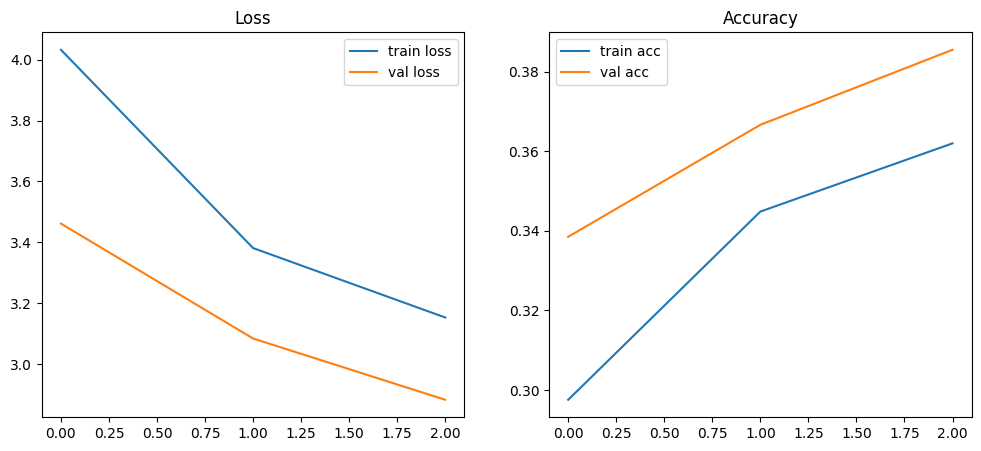

In [42]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend(); plt.title('Accuracy')
plt.show()

# 13. Build test dataset (finite; no .repeat())

- How many test steps here.

In [44]:
# 1) Re-define the helper (if not already in scope)
def count_sequences(ids):
    tot = 0
    for img_id in ids:
        if img_id not in captions or img_id not in features:
            continue
        for cap in captions[img_id]:
            tokens = tokenizer.texts_to_sequences([cap])[0]
            if len(tokens) <= max_len:
                tot += len(tokens) - 1
    return tot

test_ds = make_caption_dataset(
    captions, features, test_ids, max_len,
    batch_size=best['batch_size']
)

test_count = count_sequences(test_ids)
test_steps = test_count // best['batch_size']

test_metrics = model.evaluate(
    test_ds,
    steps=test_steps,
    verbose=2
)
print("Test Loss, Accuracy:", test_metrics)


537/537 - 37s - 68ms/step - accuracy: 0.3600 - loss: 3.5210
Test Loss, Accuracy: [3.52099871635437, 0.3599860370159149]


# 14. Caption generation & BLEU

In [45]:
def generate_caption(feat):
    text = ['startseq']
    for _ in range(max_len):
        seq = pad_sequences([tokenizer.texts_to_sequences([' '.join(text)])[0]],
                            maxlen=max_len, padding='post')
        yhat = model.predict([feat[np.newaxis], seq], verbose=0)
        word = tokenizer.index_word.get(np.argmax(yhat), None)
        if word is None or word=='endseq': break
        text.append(word)
    return text[1:]

refs, hyps = [], []
for img_id in test_ids:
    if img_id not in features: continue
    refs.append([c.split()[1:-1] for c in captions[img_id]])
    hyps.append(generate_caption(features[img_id]))

print("BLEU‑1:", corpus_bleu(refs, hyps, weights=(1,0,0,0)))
print("BLEU‑4:", corpus_bleu(refs, hyps, weights=(0.25,0.25,0.25,0.25)))

BLEU‑1: 0.4124107633168589
BLEU‑4: 0.05715647088125154


# 15. Save tokenizer and max_len

In [46]:
with open(os.path.join(OUTPUT_DIR, 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f)
with open(os.path.join(OUTPUT_DIR, 'max_length.pkl'), 'wb') as f:
    pickle.dump(max_len, f)

# 16. Generate & display captions on 3 random test images.

- Here we are doing,
    1. Rebuild the model architecture and load weights.
    2. (Re)load tokenizer and max_len if needed.
    3. Sampling‐based decoder with temperature.
    4. Pick and display 3 random test images.
    5. Plot.

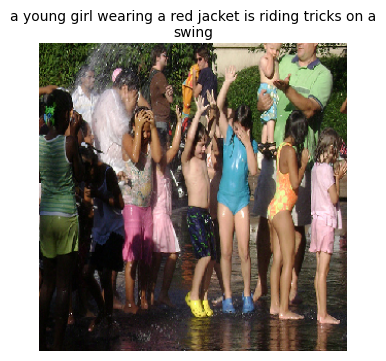

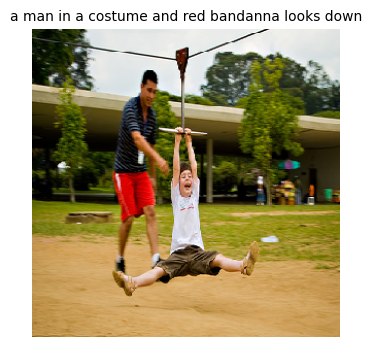

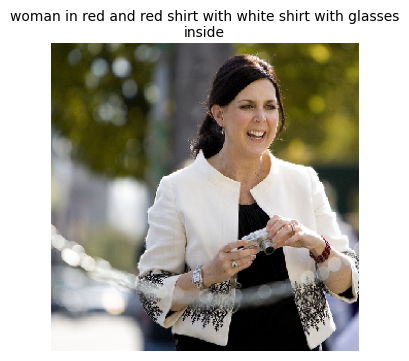

In [ ]:
model = build_model(
    embed_dim   = best['embed_dim'],
    lstm_units  = best['lstm_units'],
    drop        = best['drop'],
    lr          = best['lr']
)
model.load_weights(os.path.join(OUTPUT_DIR, 'best_cnn_lstm.h5'))

with open(os.path.join(OUTPUT_DIR, 'tokenizer.pkl'), 'rb') as f:
    tokenizer = pickle.load(f)
with open(os.path.join(OUTPUT_DIR, 'max_length.pkl'), 'rb') as f:
    max_len = pickle.load(f)

def sample_caption(feat, temperature=1.0):
    text = ['startseq']
    for _ in range(max_len):
        seq = tokenizer.texts_to_sequences([' '.join(text)])[0]
        seq = np.pad(seq, (0, max_len - len(seq)), mode='constant')
        preds = model.predict([feat[np.newaxis], np.array([seq])], verbose=0)[0]
        
        preds = np.log(preds + 1e-8) / temperature
        exp_preds = np.exp(preds)
        probs = exp_preds / np.sum(exp_preds)
        idx = np.random.choice(len(probs), p=probs)
        word = tokenizer.index_word.get(idx)
        if word is None or word == 'endseq':
            break
        text.append(word)
    return text[1:]

sample_ids = random.sample(test_ids, 3)

for img_id in sample_ids:
    img_path = os.path.join(IMAGE_DIR, img_id + '.jpg')
    img = load_img(img_path, target_size=(299,299))
    feat = features[img_id]
    
    words   = sample_caption(feat, temperature=0.8)
    caption = ' '.join(words)

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, wrap=True, fontsize=10)
    plt.show()